In [65]:
from collections import namedtuple
import glob
from itertools import product
import json
import logging
import math
import os
import random

import soundfile as sf
from pyrubberband import pyrb
import argparse
import librosa.effects
import librosa.core
import librosa.output
import numpy as np
import pydub
import tensorflow as tf
tf.enable_v2_behavior()

from tqdm.notebook import trange, tqdm

from audio_load import load_audio_from_files, audio2spec
from st_2d import scat2d
import windows as win

In [66]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

In [67]:
sr=16000

In [68]:
def load_data(p_files):    
    
    p_samples = load_audio_from_files(p_files, "wav", 3000, 8000)
    p_specs = audio2spec(p_samples, 160, 80, 640)
    p_labels = np.ones(len(p_samples))
    
    return p_samples, p_specs, p_labels

In [69]:
Clip = namedtuple('Clip', ['samples', 'start', 'end'])

In [70]:
# load negative source files
n_files = glob.glob('/scratch1/ilya/locDoc/data/LibriSpeech/train-clean-360/*/*/*.flac')
len(n_files)

104014

In [71]:
# load positive source files, with metadata
with open('data/alexa.annotated.ilya.json') as json_file:
    positive_metadata = json.load(json_file)
source_files_ = list(positive_metadata.keys())
source_files = [os.path.join('/scratch0/ilya/locDoc/data/alexa/v1/alexa', fname) for fname in source_files_]

In [72]:
def filter_for_speech(samples, sr=sr):
    samples = (samples * 2**15).astype(np.int16)
    sound = pydub.AudioSegment(
        samples.tobytes(), 
        frame_rate=sr,
        sample_width=samples.dtype.itemsize, 
        channels=1
    )
    
    sound_hi = pydub.effects.high_pass_filter(sound, 85)
    sound_mid = pydub.effects.low_pass_filter(sound_hi, 255)
    y_ = sound_mid.get_array_of_samples()
    y = np.array(y_, dtype=np.float) / np.abs(y_).max()
    return y

## Data alignment

We have access to start/end time of keywords.

For the v3 dataset: clip lengths are 31 context chunks * 1+ frames per chunk
25ms windows with 10ms hops

So 4 frames per chunk means 1240ms clip, looking back 800ms.
Shorter than this seems hard since the whole wakeword may not be present.
But lookahead then is 400ms.

In [192]:
# pick a random negative audio file
samples_bg, _ = sf.read(n_files[random.randint(0,len(n_files)-1)])

In [199]:
ipd.Audio(samples_bg, rate=sr)

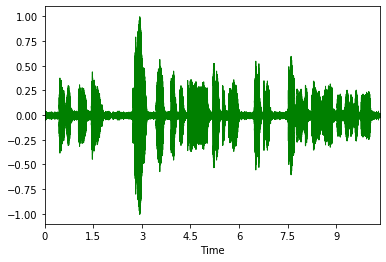

In [202]:
y_ = filter_for_speech(samples_bg)
librosa.display.waveplot(y_, sr=sr, color='green')
ipd.Audio(y_, rate=sr)

In [78]:
def pad_clip(clip, padding=(0,0)):
    pad_left, _ = padding
    y = np.pad(clip.samples, pad_width=padding, mode='constant', constant_values=0)
    return Clip(y, clip.start+pad_left, clip.end+pad_left)

def extract_other_speech_padding(samples_bg, length=48000):
    """
    Returns:
      leading Clip and trailing Clip
    """
    # try to figure out start time with filtered speech
    samples_filtered = filter_for_speech(samples_bg)
    audio_chunks = librosa.effects.split(samples_filtered, top_db=20, frame_length=320, hop_length=160)
    audio_chunks_flat = [item for sublist in audio_chunks for item in sublist]
    start = min(audio_chunks_flat)
    end = max(audio_chunks_flat)
    # print(start,len(samples_bg)-end)
    # TODO: check that start/end times are "correct," maybe close enough to front/end
    middle = (end-start) // 2
    
    if end - middle > length:
        lead = Clip(samples_bg, end - length, end)
    else:
        lead = Clip(samples_bg, middle, end)
        lead = pad_clip(lead, (length-(end - middle),0))
    
    if middle - start:
        trail = Clip(samples_bg, start, start + length)
    else:
        trail = Clip(samples_bg, start, middle)
        trail = pad_clip(trail, (0, length - (middle - start)))
        
    return lead, trail

In [210]:
lead, trail = extract_other_speech_padding(samples_bg)

In [211]:
# pick a random positive example
select_idx = random.randint(0,len(source_files)-1)
wakeword_samples, _ = sf.read(source_files[select_idx])
start, end = positive_metadata[source_files_[select_idx]]
wakeword = Clip(wakeword_samples, start, end)

In [79]:
def align_three(source_a, source_b, source_c, b_delay=0, c_delay=0):
    """
    Makes a multitrack np.array of the samples in 3 sources.
    
    
    Args:
      sources should all be of Clip type
      source_a is cut at its start, as much trailing content is included as fits
      source_c is cut at its end, as much leading content is included as fits
      source_b is not cut at all, as much leading and trailing content is included as fits
      b_delay: number samples to delay b
      c_delay: number samples to delay c
    Returns:
      np.array of output, channels=axis 1. np.array of content start end times, shape 2x3.

    There is the concept of content, track which includes padding for content, and output.

    Turn the source clips into tracks, stick the tracks in the output mux.
    """
    a_len = source_a.end - source_a.start
    b_len = source_b.end - source_b.start
    c_len = source_c.end - source_c.start
    a_start_in_out = 0
    b_start_in_out = a_start_in_out + a_len + b_delay
    c_start_in_out = b_start_in_out + b_len + c_delay
    out_len = c_start_in_out + c_len

    output = np.zeros((out_len, 3))
    labels = np.zeros((2, 3), dtype=int)

    # start cutting and fitting
    a_pad_right_len = len(source_a.samples) - source_a.end
    if a_start_in_out + a_len + a_pad_right_len > out_len:
        a_pad_right_len = out_len - (a_start_in_out + a_len)
    a_track = source_a.samples[source_a.start:(source_a.end + a_pad_right_len)]
    output[a_start_in_out:(a_start_in_out + a_len + a_pad_right_len),0] = a_track
    labels[:,0] = [a_start_in_out,a_start_in_out + a_len]

    b_pad_left_len = source_b.start
    if b_start_in_out - b_pad_left_len < 0:
        b_pad_left_len = b_start_in_out
    b_pad_right_len = len(source_b.samples) - source_b.end
    if b_start_in_out + b_len + b_pad_right_len > out_len:
        b_pad_right_len = out_len - (b_start_in_out + b_len)
    b_track = source_b.samples[(source_b.start - b_pad_left_len):(source_b.end + b_pad_right_len)]
    output[(b_start_in_out - b_pad_left_len):(b_start_in_out + b_len + b_pad_right_len),1] = b_track
    labels[:,1] = [b_start_in_out,b_start_in_out + b_len]

    c_pad_left_len = source_c.start
    if c_start_in_out - c_pad_left_len < 0:
        c_pad_left_len = c_start_in_out
    c_track = source_c.samples[(source_c.start-c_pad_left_len):source_c.end]
    output[(c_start_in_out-c_pad_left_len):(c_start_in_out + c_len), 2] = c_track
    labels[:,2] = [c_start_in_out,c_start_in_out + c_len]
    
    return output, labels
    

    
def extract_example(samples, center_chunk_start, chunk_size=640, n_right_chunks=10, n_left_chunks=20):
    """
    This is for extracting audio that will be a certain shape
    when a spectrogram is made. Each chunk will correspond to 1 or
    more columns in the spectrogram. Therefore it's best to think
    of chunk_size in terms of multiples of hop size.
    10ms = 160 samples.
    
    Args:
      center_chunk_start: idx of center in samples
      chunk_size: in samples
    Returns:
      samples cut to size
    """
    slice_right = center_chunk_start + (1+n_right_chunks)*chunk_size
    slice_left = center_chunk_start - (n_left_chunks*chunk_size)
    assert slice_left > 0, 'Not enough left padding in input'
    assert slice_right < len(samples), 'Not enough right padding in input'
    return samples[slice_left:slice_right]
    

In [80]:
def get_chunk(samples, chunk):
    return np.array(samples[chunk[0]:chunk[1]])

In [217]:
# example of aligning and extracting
output, labs = align_three(lead, wakeword, trail)
mix = output.mean(axis=1)

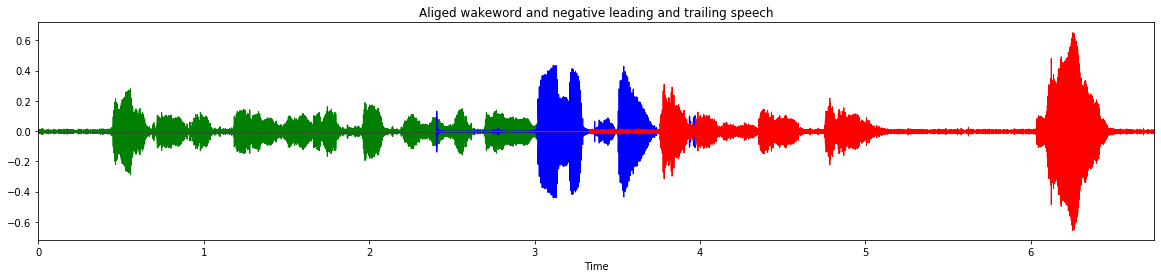

In [218]:
fig = plt.figure()
librosa.display.waveplot(np.asfortranarray(output[:,0]), sr=sr, color='green')
librosa.display.waveplot(np.asfortranarray(output[:,1]), sr=sr, color='blue')
librosa.display.waveplot(np.asfortranarray(output[:,2]), sr=sr, color='red')
plt.title('Aliged wakeword and negative leading and trailing speech')
fig.set_figwidth(20)

In [228]:
# play extracted example
jitter = np.random.choice((np.arange(0,0.25,0.05) * sr).astype(int))
print(jitter/sr)
eg_1 = extract_example(mix, labs[1,1]-jitter)
ipd.Audio(eg_1, rate=sr)

0.2


(201, 125)

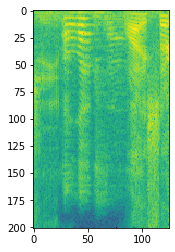

In [417]:
spec = np.abs(librosa.core.stft(eg_1, win_length=(sr // 40), hop_length=(sr // 100), n_fft=(sr // 40)))
plt.imshow(np.log(spec))
spec.shape

In [ ]:
len(eg_1)

## Time Altering

Text(0.5, 1.0, 'Lengths in ms of Wakewords')

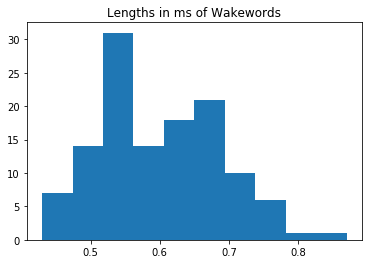

In [131]:
wakeword_lens = [(e-s)/float(sr) for (s,e) in list(positive_metadata.values())]
plt.hist(wakeword_lens);
plt.title('Lengths in ms of Wakewords')

In [146]:
shortest_i = wakeword_lens.index(min(wakeword_lens))

y_fast, _ = sf.read(source_files[shortest_i])
clip_fast = Clip(y_fast, *positive_metadata[source_files_[shortest_i]])

print((clip_fast.end - clip_fast.start) / sr)
ipd.Audio(clip_fast.samples[clip_fast.start: clip_fast.end], rate=sr)

0.43


In [154]:
longest_i = wakeword_lens.index(max(wakeword_lens))

y_slow, _ = sf.read(source_files[longest_i])
clip_slow = Clip(y_slow, *positive_metadata[source_files_[longest_i]])

print((clip_slow.end - clip_slow.start) / sr)
ipd.Audio(clip_slow.samples[clip_slow.start: clip_slow.end], rate=sr)

0.87


By these examples, seems fair to say that wakeword should be between 400 and 900ms.

In [81]:
def time_stretch_to_target(clip, target_len=0.550, sr=sr, tolerance=0.05):
    """
    Don't alter if current length is within tolerance.
    Args:
      clip: of Clip type
      target_len: length in miliseconds that clip content should be
      tolerance: in ms
    """
    cur_len = (clip.end - clip.start)/sr
    if abs(cur_len - target_len) < tolerance:
        return clip
    else:
        time_stretch = cur_len / target_len
        new_samples = pyrb.time_stretch(clip.samples, sr=sr, rate=time_stretch)
        new_start = int(clip.start / time_stretch)
        new_end = int(clip.end / time_stretch)
        return Clip(new_samples, new_start, new_end)

In [159]:
clip_fast_altered = time_stretch_to_target(clip_fast, target_len=0.6)
ipd.Audio(clip_fast_altered.samples[clip_fast_altered.start: clip_fast_altered.end], rate=sr)

In [158]:
clip_slow_altered = time_stretch_to_target(clip_slow, target_len=0.6)
ipd.Audio(clip_slow_altered.samples[clip_slow_altered.start: clip_slow_altered.end], rate=sr)

We will sample from the true distribution with a multinomial

In [430]:
lengths_ms = np.arange(0.4,0.9,0.05)
lengths_counts, _ = np.histogram(wakeword_lens, bins=len_bins)
lengths_probabilities = lengths_counts / lengths_counts.sum()
print(lengths_counts)

[ 2  7 31 20 24 21 13  4  0]


In [411]:
# sample once
lengths_ms[np.random.multinomial(1, lengths_probabilities).tolist().index(1)]

0.75

## End to End mixing

In [358]:
pitch_shift_opts = np.arange(-3,3.5,0.5).tolist()
silence_1_opts = np.arange(-0.1, 0.2, 0.05).tolist()
silence_2_opts = np.arange(-0.1, 0.2, 0.05).tolist()
loudness_opts = [0.25,0.5,1.0]
augment_opts = list(product(*[pitch_shift_opts, silence_1_opts, silence_2_opts, loudness_opts]))

In [82]:
def augment_audio(p_file, p_start_end, n_file, p_duration, pitch_shift, silence_1, silence_2, loudness):
    """
    Does everything but extraction. Outputs multiple channels.
    
    Args:
      p_duration: in ms
      overlap_1: silence in ms between speech before wakeword and wakeword, if negative there is overlap
      overlap_2: silence in ms between wakeword and speech after wakeword, if negative there is overlap
      pitch_shift: octaves to shift, can be float, -3..+3 is a reasonable range
    """
    sr = 16000
    
    wakeword_samples, _ = sf.read(p_file)
    wakeword = Clip(wakeword_samples, *p_start_end)
    wakeword = time_stretch_to_target(wakeword, target_len=p_duration, sr=sr, tolerance=0.05)
    wakeword = Clip(pyrb.pitch_shift(wakeword.samples, sr=sr, n_steps=pitch_shift), wakeword.start, wakeword.end)
    
    samples_bg, _ = sf.read(n_file)
    lead, trail = extract_other_speech_padding(samples_bg)
    
    output, labs = align_three(lead, wakeword, trail, int(silence_1*sr), int(silence_2*sr))
    
    def get_power(clip):
        return np.sqrt((clip.samples[clip.start:clip.end]**2).sum() / (clip.end-clip.start))
    k = (get_power(lead)+get_power(trail)) / (2*get_power(wakeword))
    
    output[:,1] *= k*loudness
    return output, labs

In [295]:
# pick random examples
pi = random.randint(0,len(source_files)-1)
ni = random.randint(0,len(n_files)-1)

In [399]:
# pick random augment args
args = augment_opts[random.randint(0,len(augment_opts)-1)]
rand_p_duration = lengths_ms[np.random.multinomial(1, lengths_probabilities).tolist().index(1)]
print(rand_p_duration, args)

0.55 (3.0, 0.20000000000000004, 0.0, 1.0)


In [400]:
# mux it
output, labs = augment_audio(source_files[pi], positive_metadata[source_files_[pi]], n_files[ni], rand_p_duration, *args)

In [401]:
# extract it, with some center jitter
mix = output.mean(axis=1)
jitter = np.random.choice((np.arange(0,0.45,0.05) * sr).astype(int))
print(jitter/sr)
eg_1 = extract_example(mix, labs[1,1]-jitter)
ipd.Audio(eg_1, rate=sr)

0.05


In [504]:
# write to wav
eg_as_ints = (eg_1 * 2**15).astype(np.int16)
audio_segment = pydub.AudioSegment(
    eg_as_ints.tobytes(), 
    frame_rate=sr,
    sample_width=eg_as_ints.dtype.itemsize, 
    channels=1
)
audio_segment.export('/scratch0/ilya/locDownloads/eg.wav', format='wav')

## Negative examples

In [73]:
def align_two(source_a, source_b, b_delay=0):
    """
    Makes a multitrack np.array of the samples in 2 sources.
    
    
    Args:
      sources should all be of Clip type
      source_a is cut at its start, as much trailing content is included as fits
      source_c is cut at its end, as much leading content is included as fits
      b_delay: number samples to delay b
    Returns:
      np.array of output, channels=axis 1. np.array of content start end times, shape 2x2.

    There is the concept of content, track which includes padding for content, and output.

    Turn the source clips into tracks, stick the tracks in the output mux.
    """
    a_len = source_a.end - source_a.start
    b_len = source_b.end - source_b.start
    a_start_in_out = 0
    b_start_in_out = a_start_in_out + a_len + b_delay
    out_len = b_start_in_out + b_len

    output = np.zeros((out_len, 2))
    labels = np.zeros((2, 2), dtype=int)

    # start cutting and fitting
    a_pad_right_len = len(source_a.samples) - source_a.end
    if a_start_in_out + a_len + a_pad_right_len > out_len:
        a_pad_right_len = out_len - (a_start_in_out + a_len)
    a_track = source_a.samples[source_a.start:(source_a.end + a_pad_right_len)]
    output[a_start_in_out:(a_start_in_out + a_len + a_pad_right_len),0] = a_track
    labels[:,0] = [a_start_in_out,a_start_in_out + a_len]

    b_pad_left_len = source_b.start
    if b_start_in_out - b_pad_left_len < 0:
        b_pad_left_len = b_start_in_out
    b_track = source_b.samples[(source_b.start-b_pad_left_len):source_b.end]
    output[(b_start_in_out-b_pad_left_len):(b_start_in_out + b_len), 1] = b_track
    labels[:,1] = [b_start_in_out,b_start_in_out + b_len]
    
    return output, labels

In [85]:
def mix_two_negatives(n_file1, n_file2, output_len, silence, output_advance, loudness):
    """
    Args:
      silence: in ms
      output_advance: in ms. If 0 starts from the second clip.
    """
    a, _ = sf.read(n_file1)
    b, _ = sf.read(n_file2)
    
    _, trail = extract_other_speech_padding(a)
    lead, _ = extract_other_speech_padding(b)
    output, labs = align_two(lead, trail, int(silence*sr))
    
    def get_power(clip):
        return np.sqrt((clip.samples[clip.start:clip.end]**2).sum() / (clip.end-clip.start))
    k = get_power(lead) / get_power(trail)
    output[:,1] *= k*loudness

    mixed = output.mean(axis=1)
    
    s = max(labs[1,0]-int(output_advance*sr), 0)
    e = s + output_len
    return mixed[s:e]

In [86]:
ni1 = random.randint(0,len(n_files)-1)
ni2 = random.randint(0,len(n_files)-1)

In [87]:
mix = mix_two_negatives(n_files[ni1], n_files[ni2], 19840, 0, 0.4, 1.0)

In [88]:
ipd.Audio(mix, rate=sr)

## Loading audio and spectrogram from tfrecord dataset

In [107]:
tfrecord_file = '/scratch0/ilya/locDoc/data/alexa/v3/train/_positive_00_0000.tfrecord'
#tfrecord_file = '/scratch0/ilya/locDoc/data/alexa/v3/train/_negative_00_0000.tfrecord'

In [108]:
examples = []
specs = []
limit = 100
for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)
    
    spec_shape = eg_np.features.feature["spectrogram_shape"].int64_list.value
    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec = np.array(spec).reshape(spec_shape)
    specs.append(spec)
    if i > limit:
        break

In [131]:
i = random.randint(0,limit-1)

In [132]:
ipd.Audio(examples[i], rate=16000)

(200, 124)


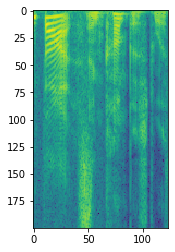

In [98]:
plt.figure()

# y = np.array(examples[26]).astype(float) / 2**15
# spec = np.abs(librosa.core.stft(y, win_length=closest_power_of_2(sr // 50), hop_length=closest_power_of_2(sr // 100), n_fft=2*closest_power_of_2(sr // 50)))
# plt.imshow(spec)
print(specs[i].shape)
plt.imshow(np.log(specs[i]))

In [134]:
specs[i][0,:].shape

(124,)

## Label start/end times of keywords

In [985]:
def detect_leading_silence(sound, silence_threshold=-50.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [353]:
def chunk_duration_s(chunk, sr=16000):
    return (chunk[1]-chunk[0]) / float(sr)

In [992]:
def source_file_to_start_sample(source_file):
    sound = pydub.AudioSegment.from_file(source_file, format="wav")
    sound_hi = pydub.effects.high_pass_filter(sound, 85)
    sound_mid = pydub.effects.low_pass_filter(sound_hi, 255)
    y = np.array(sound_mid.get_array_of_samples(), dtype=np.float64) / 2**15

    audio_chunks = []
    silence_db = 60
    while silence_db > 0 and (len(audio_chunks) < 1 or np.array([chunk_duration_s(c) for c in audio_chunks]).max() > 0.8 or np.array([chunk_duration_s(c) for c in audio_chunks]).max() < 0.25):
        silence_db -= 5
        audio_chunks = librosa.effects.split(y, top_db=silence_db, frame_length=sr // 40, hop_length=sr // 100)

    if len(audio_chunks) == 0:
        return 0
#     print(silence_db)
    chunk_lens = [chunk_duration_s(c) for c in audio_chunks]
    longest_chunk_i = chunk_lens.index(max(chunk_lens))
    return audio_chunks[longest_chunk_i]

### Interactive start/end time labelling

In [ ]:
source_files = glob.glob('/scratch0/ilya/locDoc/data/alexa/v1/alexa/*/*.wav')

In [1913]:
metadata = {}

In [1904]:
# load source files
with open('data/alexa.annotated.ryan_todo.json') as json_file:
    metadata_todo = json.load(json_file)
source_files = list(metadata_todo.keys())
source_files = [os.path.join('/scratch0/ilya/locDoc/data/alexa/v1/alexa', fname) for fname in source_files]

In [1907]:
# Init
ci = -1

In [1915]:
# Next
ci += 1
user_start = None
user_end = None

1
Segment is 650ms long


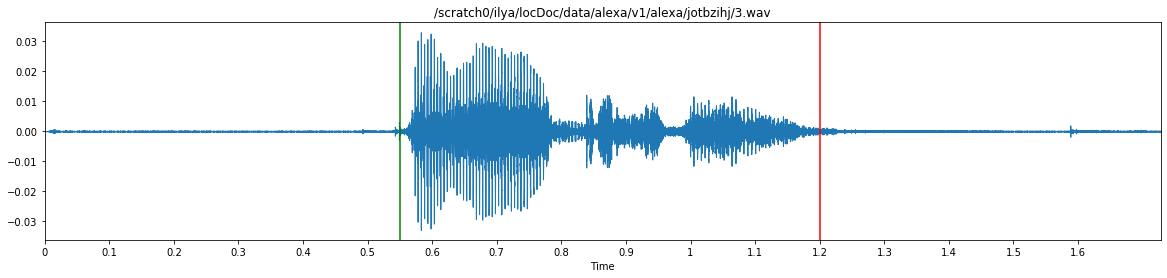

In [1919]:
# Test
print(ci)
fig = plt.figure()
y, sr = sf.read(source_files[ci])
try:
    guess_start, guess_end = source_file_to_start_sample(source_files[ci])
except:
    guess_start, guess_end = [0, len(y)]
selected_start = user_start if user_start is not None else guess_start
selected_end = user_end if user_end is not None else guess_end
librosa.display.waveplot(y, sr=sr)
plt.title(source_files[ci])
plt.axvline(x=selected_start/float(sr), c='green')
plt.axvline(x=selected_end/float(sr), c='red')
plt.xticks(np.array(list(range(int(len(y)/float(sr)*10)))) / 10.0)
fig.set_figwidth(20)
print('Segment is %ims long' % int((selected_end-selected_start)/float(sr)*1000) )
# fig
ipd.Audio(y[selected_start:selected_end], rate=sr)

In [1917]:
# Edit (Optional)
user_start = int(0.55 * sr)

In [1918]:
# Edit (Optional)
user_end = int(1.2 * sr)

In [1920]:
# Save in memory
file_id = os.path.join(*source_files[ci].split('/')[-2:])
print(file_id, selected_start, selected_end)
metadata[file_id] = [int(selected_start), int(selected_end)]
len(metadata)

jotbzihj/3.wav 8800 19200


2

In [1921]:
# Write memory to file
with open('data/alexa.annotated.xxx.json', 'w') as metafile:
    json.dump(metadata, metafile)